This notebook aims to calculate the variance of the measurements of the speed of the Thymio and calculate the conversion factor of speed. 
It was mainly inspired by the correction of the exercice session 8 of the course $\textit{Basics of mobile robotics}$ by Pr. Mondada.

In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 0102d6c0-0c6c-479f-8406-474092b0daba

In [2]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [3]:
acquire_data = True #False
Ts = 0.1
thymio_data = []

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data():
    thymio_data.append({
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})
    

if acquire_data:
    await node.wait_for_variables() # wait for Thymio variables values
    rt = RepeatedTimer(Ts, get_data) # it auto-starts, no need of rt.start()

    try:
        # time.sleep would not work here, use asynchronous client.sleep method instead
        await client.sleep(5)
        node.send_set_variables(motors(50, 50))
        await client.sleep(20) 
    finally:
        rt.stop() # better in a try/finally block to make sure the program ends!
        node.send_set_variables(motors(0, 0))

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [5]:
print(thymio_data)

[{'left_speed': -3, 'right_speed': 0}, {'left_speed': -8, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_spee

To go from Thymio speed to mm/s, the conversion factor is 0.48
The speed variance in mm^2/s^2 is 4.079861111111112


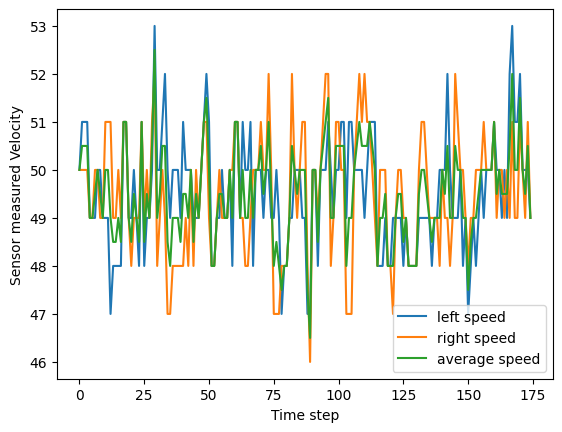

In [ ]:
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
plt.plot(l_speed[55:], label="left speed")
plt.plot(r_speed[55:], label="right speed")
plt.plot(avg_speed[55:], label="average speed")
plt.xlabel("Time step")
plt.ylabel("Sensor measured Velocity")
plt.legend()


mms_per_pixel = 9.75 # mm/pixel
# measure the real life speed of the Thymio several times and take the average
thymio_true_speed = (36)*10/15 # mm/s (dist/time) 
conversion_factor = thymio_true_speed/50 # in mm/thymio
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(conversion_factor)) # mm/s speed = conversion_factor * Thymio speed
var_speed = np.var(np.array(avg_speed[55:]*conversion_factor)) # took from 55 to avoid the initial transient and devid by the conversion factor
std_speed = np.std(np.array(avg_speed[55:]*conversion_factor))
print("The speed variance in mm^2/s^2 is {}".format(var_speed))
print("The speed variance in pixels^2/s^2 is {}".format(var_speed /(mms_per_pixel**2)))